In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import os
from typing import Tuple, List
from numpy.random import choice
import uuid
from tqdm import tqdm

In [2]:
# Prepare the data in the correct order
PATH = 'data'
football_league = 'La Liga'
filename = 'LL2022-2023.csv'

df_ = pd.read_csv(os.path.join(PATH, football_league, filename), sep = ';')


In [3]:
# Setup of the variables to odds
dictionary_columns = {'HomeTeam' : 'home', 'AwayTeam' : 'away', 
    'FTR' : 'result', 'B365H': 'p_homewin', 'B365D': 'p_draw', 
    'B365A': 'p_awaywin',
}

columns_ = ['HomeTeam', 'AwayTeam', 'FTR', 
    'B365H','B365D','B365A',]

df = df_[columns_].copy()
df.columns = [dictionary_columns.get(x, x) for x in df.columns]

In [4]:
def compute_probabilities(tuple_odds : Tuple) -> np.array:
    """Compute the probability of the home team winning, drawing and losing"""
    array_odds = np.array(tuple_odds)
    p_array_odds = 1 / array_odds
    probabilities = p_array_odds / np.sum(p_array_odds)
    
    return probabilities

def _softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / (np.exp(x).sum(axis=0))

def _modify_probabilities(probabilities : np.array, index_to_modify : int, element_to_modify : float) -> np.array:
    """Modify the probabilities based on the person type using a dictionary"""
    probabilities[index_to_modify] = probabilities[index_to_modify] + element_to_modify

    return _softmax(probabilities)

def modify_probabilities(probabilities : np.array, person_type : str, alpha : float = 1) -> np.array:
    """Modify the probabilities based on the person type using a dictionary"""

    if person_type == 'normal':
        return probabilities

    elif person_type == 'optimistic':
        return np.array([_modify_probabilities(p, p.argmax(), alpha) for p in probabilities])
        
    elif person_type == 'pessimistic':
        return np.array([_modify_probabilities(p, p.argmin(), alpha) for p in probabilities])


In [5]:
# Apply the function to the dataframe using the columns p_homewin, p_draw, p_awaywin as an arguments
columns_probabilities = ['p_homewin', 'p_draw', 'p_awaywin']
df[columns_probabilities] = df[columns_probabilities].apply(compute_probabilities, axis = 1, result_type = 'expand')

In [38]:
TOTAL_MATCHES = df.shape[0]
REAL_RESULTS = df['result'].values

class Player:
    def __init__(self, id : str, player_type : str):
        self.id = id
        initial_probs = df[columns_probabilities].values
        self.player_type = player_type
        self.probs = modify_probabilities(initial_probs, person_type = self.player_type)
        self.results = None
        self.scores = np.array([])

    def sequence_points(self):
        """Compute the sequence of points"""
        self._simulate_competition()
        points_date = np.cumsum(self.scores)

        return points_date

    def _simulate_competition(self):
        """Simulate the entire competition, returning the sequence of scores"""
        self.scores = np.array([])
        for id_match in range(TOTAL_MATCHES):
            score = self._compute_score(self._simulate_one_game(id_match), id_match)
            self.scores = np.append(self.scores, score)

    def _compute_score(self, result : str, index : int):
        score_index = np.sum(result == REAL_RESULTS[index])
        return score_index

    def _simulate_one_game(self, index : int):
        teams_options = ['H', 'D', 'A']
        result = choice(teams_options, 1, p = self.probs[index])[0]
        return result

    def _simulate_all_games(self):
        teams_options = ['H', 'D', 'A']
        self.results = [choice(teams_options, 1, p = prob)[0] for prob in self.probs]

    def _compute_all_score(self):
        if self.results is None:
            self._simulate_all_games()
        else:
            pass
        self.score = np.sum(self.results == REAL_RESULTS)
        
        return self.score


class Cup(Player):
    def __init__(self, players : List[Player] = None, n_players : int = 20, frac_types : Tuple = (1, 0, 0)):
        if players is None:
            self.n_players = n_players
            self.frac_types = frac_types
            self.players = self._generate_players(self.n_players, self.frac_types)
        else:
            self.players = players

    def _generate_players(self, n_players : int, frac_types : Tuple = (1, 0, 0)):
        type_players_ = ['normal', 'optimistic', 'pessimistic']
        type_players = [choice(type_players_, 1, p = frac_types)[0] for _ in range(n_players)]
        players = [Player(str(uuid.uuid4()), player_type) for player_type in type_players]

        return players

    def simulate_games(self, generate_orders : bool = False):
        """Simulate all the games and the position"""
        ids = [player.id for player in self.players]
        player_types = [player.player_type for player in self.players]
        scores_players = np.array([player.sequence_points() for player in self.players])

        df_scores = pd.DataFrame({'id' : ids, 'player_type' : player_types})
        for id in range(TOTAL_MATCHES):
            df_scores[f'score_{id}'] = scores_players[:, id]
            
            if generate_orders:
                df_scores[f'score_{id}'] = df_scores[f'score_{id}'].rank(ascending = False, method = 'first')

        return df_scores

class Simulation(Cup):
    def __init__(self, players : List[Player] = None, n_simulations : int = 1000):
        self.n_simulations = n_simulations
        self.players = players

    def simulate(self, show_progress = False):
        results = []
        for _ in tqdm(range(self.n_simulations), disable = not show_progress):
            cup = Cup(players = self.players)
            results.append(cup.simulate_games(generate_orders = True))

        return results


In [87]:
# This module analyze the results of the simulation
def compute_mean_position(results : List[pd.DataFrame]):
    """Compute the mean position of the players"""
    df_results = pd.concat(results)
    df_results = df_results.groupby(['id', 'player_type']).mean().reset_index()
    return df_results

# Generate the plot of the mean positions as a line plot
def plot_results(df : pd.DataFrame, frac_types : Tuple = (1, 0, 0)):
    """Plot the results of the simulation"""
    plt.style.use("bmh")
    _, ax = plt.subplots(figsize = (12, 8))
    dicc_colors_ = {
        'normal' : '#fa695f',
        'optimistic' : '#5ec259',
        'pessimistic' : '#fa5fa2'
    }

    for player in df['id'].unique():
        df_player_type = df[df['id'] == player]
        player_type = df_player_type['player_type'].values[0]
        
        x = list(range(len(df.columns[2:])))
        y = df_player_type.iloc[:,2:].values[0]
        ax.plot(x, y, color = dicc_colors_[player_type])

    ax.set_title('Mean position of the players', fontsize = 20)
    ax.set_xlabel('Match')
    ax.set_ylabel('Mean position')

    colors_ = list(dicc_colors_.values())
    colors = [colors_[i] for i, type in enumerate(frac_types) if type > 0]
    lines = [Line2D([0], [0], color=c, linewidth=3) for c in colors]
    labels_ =  ['Normal', 'Optimistic', 'Pessimistic']
    labels = [label for i, label in enumerate(labels_) if frac_types[i] > 0]
    
    print(colors, labels)
    plt.legend(lines, labels, loc = 'upper right', fontsize = 13)
    plt.show()


In [83]:
# Create a simulation
n_players = 30
frac_types = (1/3, 1/3, 1/3)
n_simulations = 1000

tournament = Cup(n_players = n_players, frac_types = frac_types)
players = tournament.players

  0%|          | 0/1000 [00:00<?, ?it/s]/var/folders/ng/w0kgmvm534n588rf68vx2wtm0000gn/T/ipykernel_1803/1052422792.py:74: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_scores[f'score_{id}'] = scores_players[:, id]
100%|██████████| 1000/1000 [03:01<00:00,  5.51it/s]


['#fa695f', '#5ec259', '#fa5fa2'] ['Normal', 'Optimistic', 'Pessimistic']


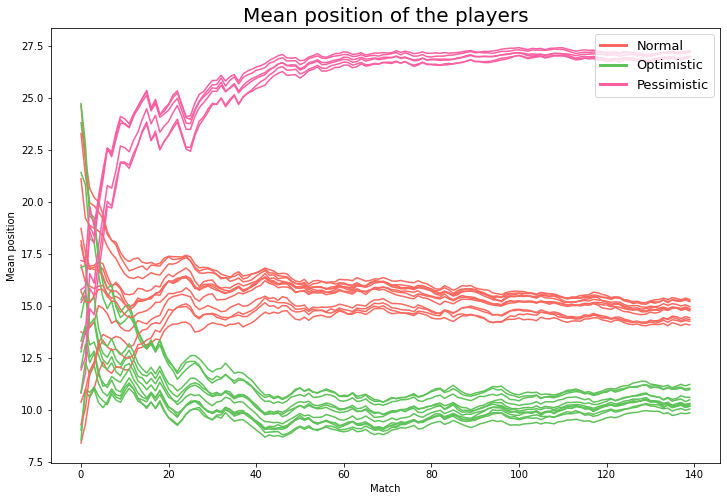

In [86]:
simulation = Simulation(players = players, n_simulations = n_simulations)
results = simulation.simulate(show_progress = True)
mean = compute_mean_position(results)

['#fa695f', '#5ec259', '#fa5fa2'] ['Normal', 'Optimistic', 'Pessimistic']


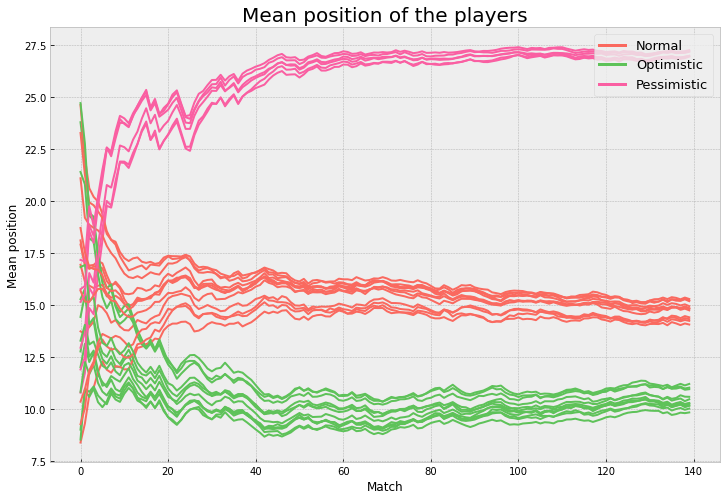

In [88]:
plot_results(mean, frac_types = frac_types)